##          ANALYSIS OF AIR POLLUTION LEVELS AND ITS CONTRIBUTING FACTORS

## Step 1. Understanding dataset

In [1]:
%matplotlib inline

In [4]:
import os
import sys

# Import required libraries
import pandas as pd
import numpy as np

#For visuaization
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from math import sqrt

#Sci-kit 
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost.sklearn import XGBRegressor

In [5]:
#Setting the figure style and size
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [14,9]

In [6]:
#loading the data (HK roadside stations, 1Jul2017-30Jun2020)
df = pd.read_csv('RAW_Central_Roadside_Jul2017_Jun2020.csv')

In [7]:
#Lets look at the data
df.head()

,YEAR,MONTH,DAY,DATE,HOUR,STATION,CO,FSP,NO2,NOX,O3,RSP,SO2,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,2017,7,1,1/7/2017,1,CENTRAL,24,1,35,76,8,6,8,NaN,NaN,NaN
1,2017,7,1,1/7/2017,2,CENTRAL,19,N.A.,20,34,15,N.A.,8,NaN,NaN,NaN
2,2017,7,1,1/7/2017,3,CENTRAL,42,N.A.,31,67,7,N.A.,9,NaN,NaN,NaN
3,2017,7,1,1/7/2017,4,CENTRAL,26,0,29,59,8,0,7,NaN,NaN,NaN
4,2017,7,1,1/7/2017,5,CENTRAL,33,0,32,79,9,3,8,NaN,NaN,NaN


In [8]:
# Remove the last 3 empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,YEAR,MONTH,DAY,DATE,HOUR,STATION,CO,FSP,NO2,NOX,O3,RSP,SO2
0,2017,7,1,1/7/2017,1,CENTRAL,24,1,35,76,8,6,8
1,2017,7,1,1/7/2017,2,CENTRAL,19,N.A.,20,34,15,N.A.,8
2,2017,7,1,1/7/2017,3,CENTRAL,42,N.A.,31,67,7,N.A.,9
3,2017,7,1,1/7/2017,4,CENTRAL,26,0,29,59,8,0,7
4,2017,7,1,1/7/2017,5,CENTRAL,33,0,32,79,9,3,8


We can observe null values **(N.A.)** in the FSP and RSP columns

In [9]:
# Total number of null values in FSP
df["FSP"].str.contains("N.A.").sum()

1040

In [10]:
# Total number of null values in RSP
df["RSP"].str.contains("N.A.").sum()

1041

In [11]:
# Total number of rows
df.shape

(24840, 13)

In [12]:
# For our convenience, convert string "N.A." into np.nan
df = df.replace('N.A.',np.nan)

In [13]:
# Lets understand the data types of the columns
df.dtypes

YEAR        int64
MONTH       int64
DAY         int64
DATE       object
HOUR        int64
STATION    object
CO         object
FSP        object
NO2        object
NOX        object
O3         object
RSP        object
SO2        object
dtype: object

In [14]:
# Some columns are not in right data types, convert them into right types.
df[["CO", "FSP", "NO2", "NOX", "O3", "RSP", "SO2"]] = df[["CO", "FSP", "NO2", "NOX", "O3", "RSP", "SO2"]].apply(pd.to_numeric)
df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
df.dtypes

YEAR                int64
MONTH               int64
DAY                 int64
DATE       datetime64[ns]
HOUR                int64
STATION            object
CO                float64
FSP               float64
NO2               float64
NOX               float64
O3                float64
RSP               float64
SO2               float64
dtype: object

In [15]:
# We can see the year, month, day and hour can be combined to show the data & Time
# However, this line is not needed since the date and time have been pre-extracted already. 

#df["datetime"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [15]:
df.head()

,YEAR,MONTH,DAY,DATE,HOUR,STATION,CO,FSP,NO2,NOX,O3,RSP,SO2
0,2017,7,1,2017-07-01,1,CENTRAL,24.0,1.0,35.0,76.0,8.0,6.0,8.0
1,2017,7,1,2017-07-01,2,CENTRAL,19.0,NaN,20.0,34.0,15.0,NaN,8.0
2,2017,7,1,2017-07-01,3,CENTRAL,42.0,NaN,31.0,67.0,7.0,NaN,9.0
3,2017,7,1,2017-07-01,4,CENTRAL,26.0,0.0,29.0,59.0,8.0,0.0,7.0
4,2017,7,1,2017-07-01,5,CENTRAL,33.0,0.0,32.0,79.0,9.0,3.0,8.0


In [19]:
#Removing unneeded features
df = df.drop(['STATION','YEAR','DAY'], axis = 1)
#Add one more feature for 'day of week' (DOW)
df['DOW'] = df.DATE.dt.day_name()
df.columns

Index(['MONTH', 'DATE', 'HOUR', 'CO', 'FSP', 'NO2', 'NOX', 'O3', 'RSP', 'SO2',
       'DOW'],
      dtype='object')

## Step 2. Visualizing Features

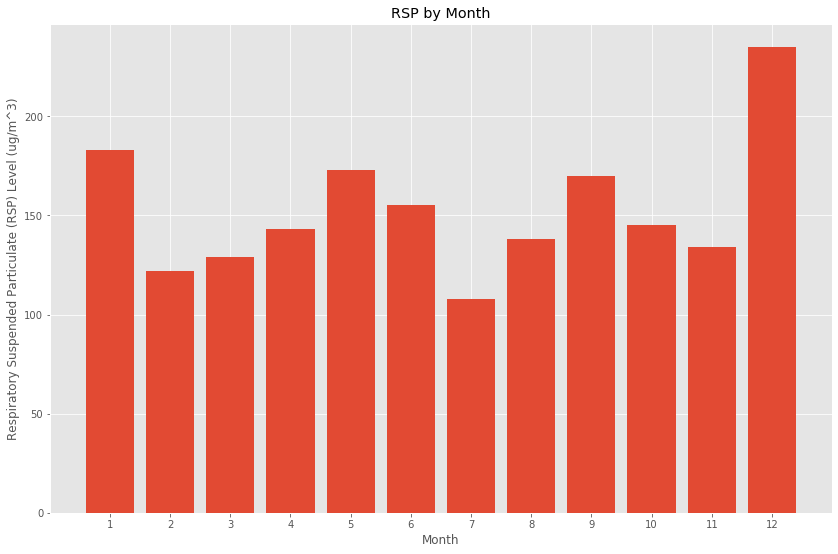

In [26]:
#Let's plot the various features (RSP, other air pollutants, etc) to find any relationships.
#Lets start with month
plt.bar(df['MONTH'],df['RSP'])
plt.xlabel('Month')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Month')
plt.xticks(ticks=range(1, 13), labels=np.linspace(1, 12, num=12, endpoint=True).astype(int))
plt.show()

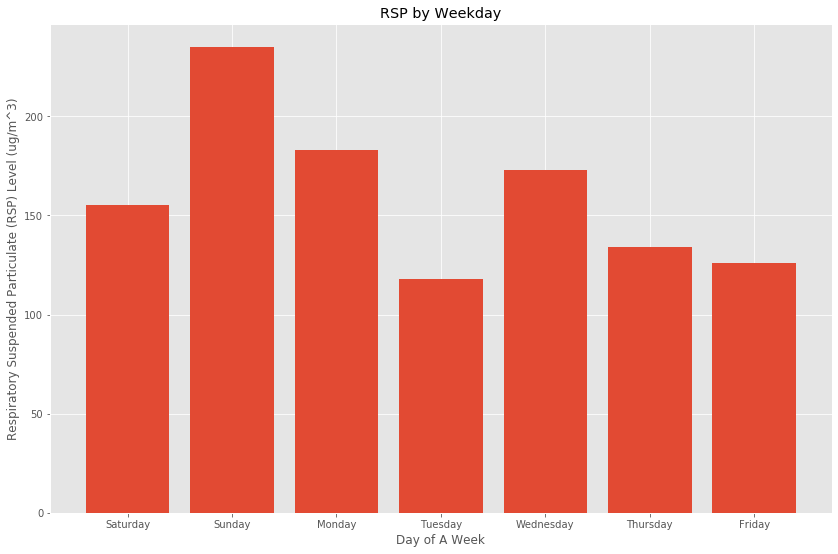

In [44]:
#Studying the weekday  
plt.bar(df['DOW'],df['RSP'])
plt.xlabel('Day of A Week')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Weekday')
plt.show()

Hong Kong winter last from Novemeber to January. From the plot above, we can clearly see that the winter months (Dec and Jan) are higher in RSP level; however, a great drop is usually occured in February and July. Also, the second graph showed that Sunday has the highest level of RSP and Tuesday has the lowest.

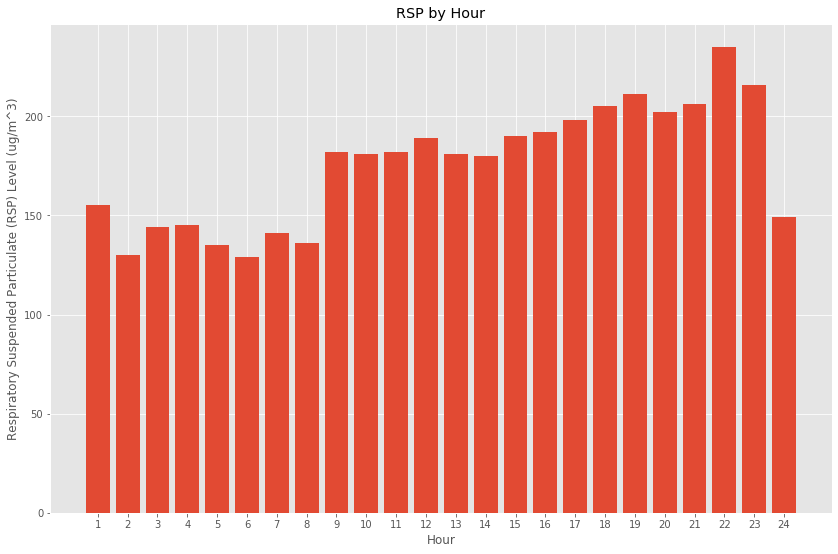

In [29]:
#Studying the hour of the day 
plt.bar(df['HOUR'],df['RSP'])
plt.xlabel('Hour')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Hour')
plt.xticks(ticks=range(1,25), labels=np.linspace(1,24,num=24,endpoint=True).astype(int))
plt.show()

By observing the plot by hours of a day above, the RSP level remains in relatively high level during daytime and evening (9 to 21), it reaches the highest just before the midnight (22 ro 23) and drops afterwards (0 to 8) until morning (9 to 12).

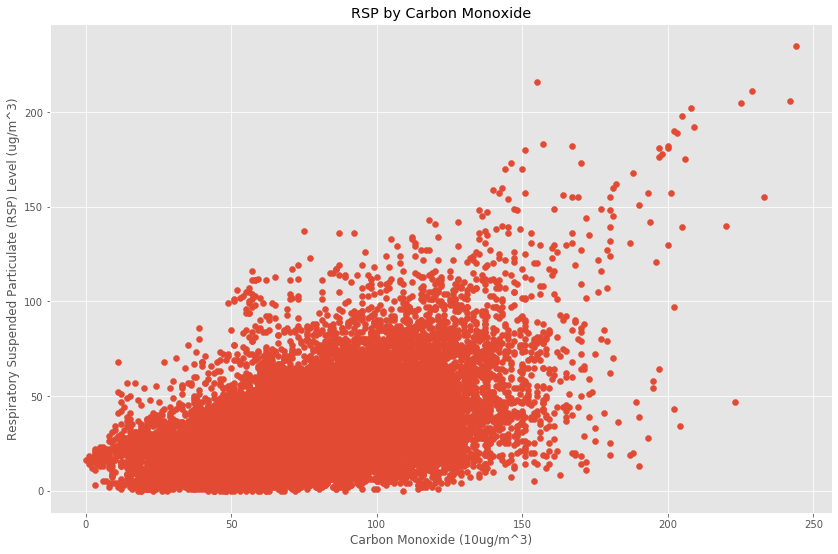

In [42]:
# Studying the relationship between carbon monoxide (CO) and RSP
plt.scatter(df['CO'],df['RSP'])
plt.xlabel('Carbon Monoxide (10ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Carbon Monoxide')
plt.show()

From this graph above, it shows there is a positive relationship between CO level and RSP level. It indicates that both CO and RSP may come from a same pollution source, and hence, the more the pollution source, the higher levels both RSP and CO.

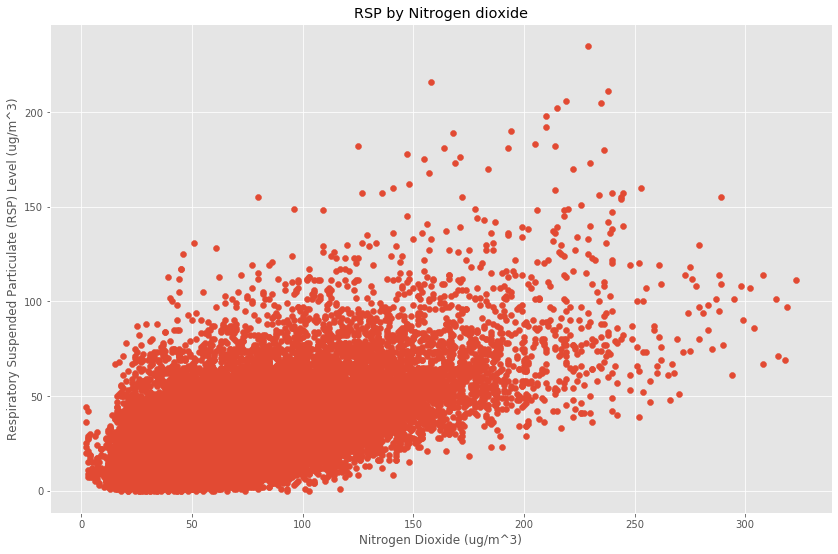

In [41]:
#Studying the relationship between nitrogen dioxide (NO2) and RSP.
plt.scatter(df['NO2'],df['RSP'])
plt.xlabel('Nitrogen Dioxide (ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Nitrogen dioxide')
plt.show()

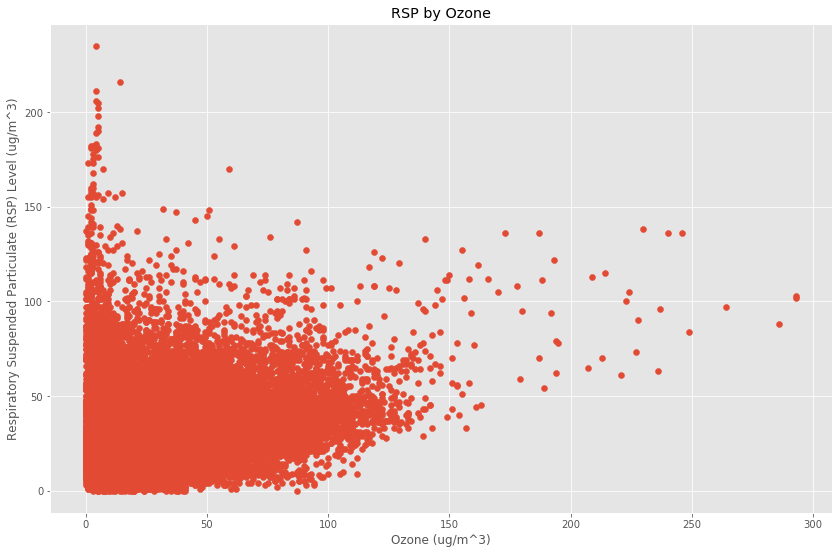

In [40]:
#Studying the relationship between ozone (O3) and RSP
plt.scatter(df['O3'],df['RSP'])
plt.xlabel('Ozone (ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Ozone')
plt.show()

From the figure above, interestingly, RSP level seems higher when ozone level is lower.

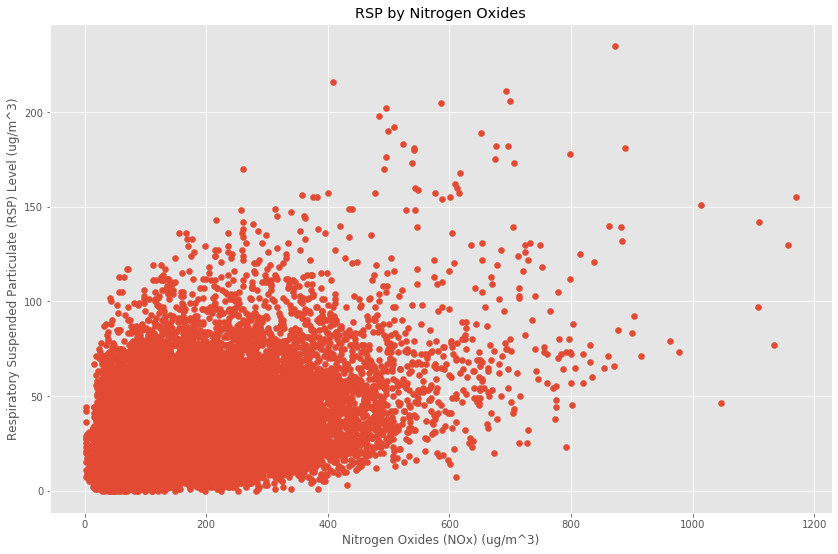

In [39]:
#Studying the relationship between nitrogen oxides (NOx) and pm2.5
plt.scatter(df['NOX'],df['RSP'])
plt.xlabel('Nitrogen Oxides (NOx) (ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Nitrogen Oxides')
plt.show()

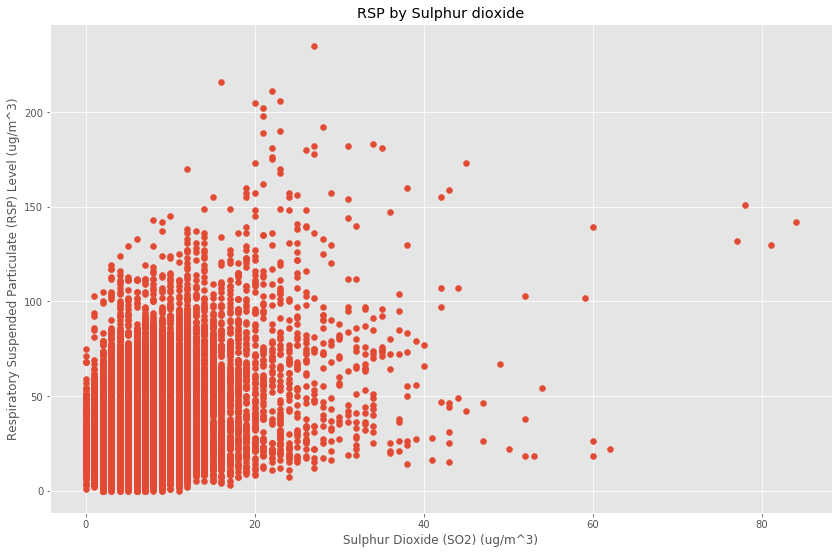

In [38]:
#Studying the relationship between sulphur dioxide (SO2) and pm2.5
plt.scatter(df['SO2'],df['RSP'])
plt.xlabel('Sulphur Dioxide (SO2) (ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) Level (ug/m^3)')
plt.title('RSP by Sulphur dioxide')
plt.show()

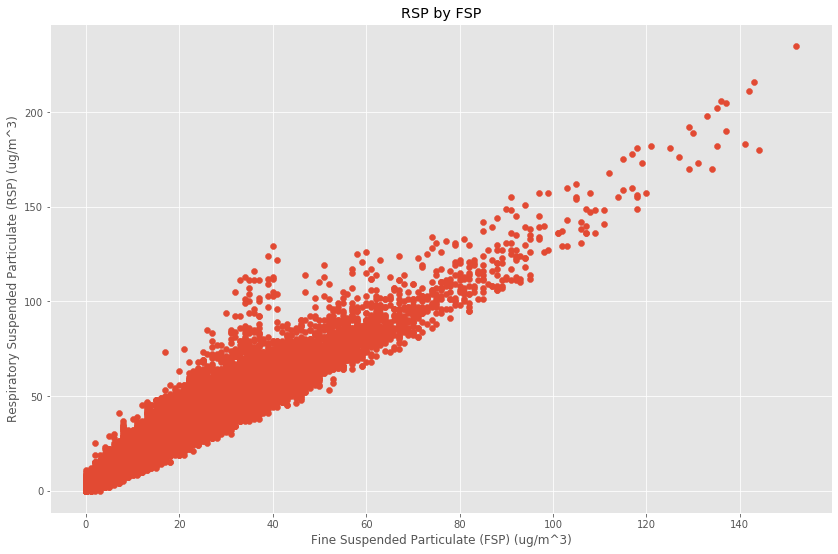

In [37]:
#Studying the relationship between FSP and RSP
plt.scatter(df['FSP'],df['RSP'])
plt.xlabel('Fine Suspended Particulate (FSP) (ug/m^3)')
plt.ylabel('Respiratory Suspended Particulate (RSP) (ug/m^3)')
plt.title('RSP by FSP')
plt.show()

Unsurprisingly, a positive relationship occurs between RSP and FSP, it is surely because RSP and FSP are come from the same sources and they are very likely colinear. In the later part of the modeling, we should try not to set FSP as one of the independent variable. 

## Determinations made from visualizations

1. Higher **ozone** seems to have lower RSP.
2. **FSP** and **CO** seem to have positive relationship with RSP.
3. RSP is higher during **daytime until midnight** and **winter** in season.

All four have the possibility of being good predictors.

## Step 2. Handling Outliers and Missing values

First let us visualise the time-series data and visualy let us spot the outliers.

In [51]:
#time series visualization
def time_series(start, end):
    import datetime 
    time_series_df = df[['DATE', 'RSP']].loc[(df[['DATE', 'RSP']]['DATE'] >= datetime.datetime.strptime(start, "%Y%m%d")) & (df[['DATE', 'RSP']]['DATE'] <= datetime.datetime.strptime(end, "%Y%m%d"))]
    x = time_series_df[time_series_df['DATE'].notnull()].groupby(['DATE'], as_index=False).mean().DATE
    y = time_series_df[time_series_df['DATE'].notnull()].groupby(['DATE'], as_index=False).mean().RSP
    plt.plot(x,y)
    plt.xlabel('Date')
    plt.ylabel('Mean RSP Level')
    plt.title('RSP Time Series')
    return plt.show();

/home/yikylee/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


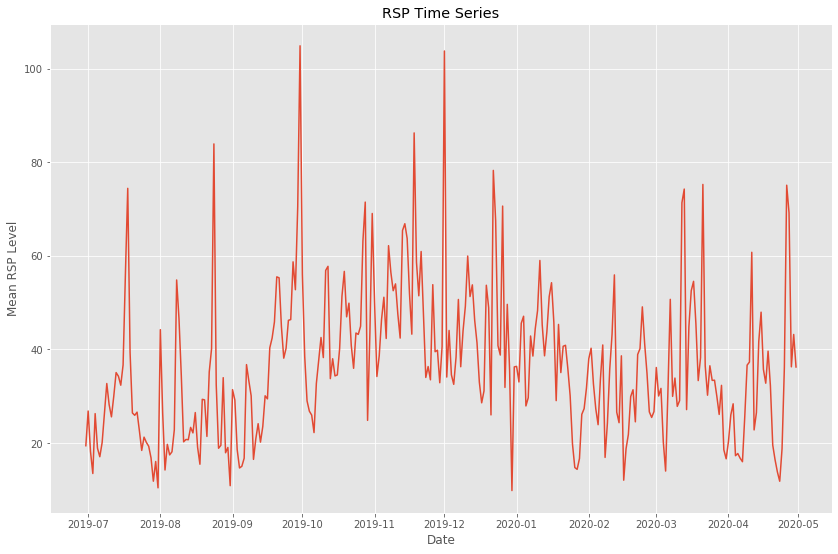

In [52]:
#Visualizing the data for the given years
time_series('20190630', '20200701')

In [53]:
# As we found that some days did not have RSP values, we need to take a look which dates have NA value.
df['RSP'].isnull().sum()

1041

The graph above shows two highest peaks through 2019-07 to 2020-05, which are at around the beginnings of October and December 2020.

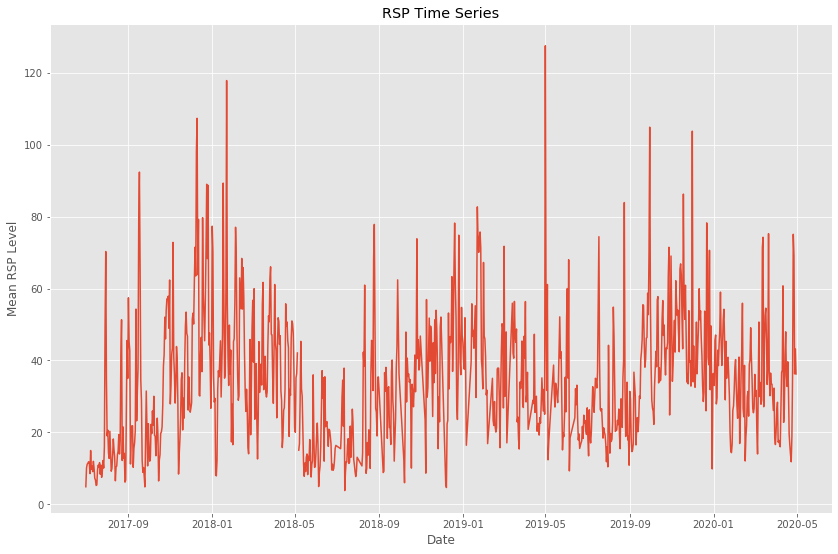

In [54]:
time_series('20170630','20200701')

Throught 2017-09 to 2020-05, we can see a **general increase of RSP usually between Sep to Jan**, and then a **general decrease between Jan to Jun**.

## Creating previous value features  (This will be considered after normal prediction)

#### Origianl comment for the origianl models.
In my first runs through the model my performance was not ideal. I theorized this is because our current data ignores all previous data. As you can imagine air pollution rises and falls gradually. However in our dataset this information does not exist. As a result I copied and shifted our features to create previous hour features for everything except time going back 5 hours. I found this was the optimal number as extra hours has no noticeable performance increase and fewer hours reduced performance.

In [31]:
df['pm2.5_1'] = df['pm2.5'].shift(periods=1)
df['TEMP_1'] = df.TEMP.shift(periods=1)
df['Iws_1'] = df.Iws.shift(periods=1)
df['DEWP_1'] = df.DEWP.shift(periods=1)
df['cbwd_1'] = df.cbwd.shift(periods=1)
df['pm2.5_2'] = df['pm2.5'].shift(periods=2)
df['TEMP_2'] = df.TEMP.shift(periods=2)
df['Iws_2'] = df.Iws.shift(periods=2)
df['DEWP_2'] = df.DEWP.shift(periods=2)
df['cbwd_2'] = df.cbwd.shift(periods=2)
df['pm2.5_3'] = df['pm2.5'].shift(periods=3)
df['TEMP_3'] = df.TEMP.shift(periods=3)
df['Iws_3'] = df.Iws.shift(periods=3)
df['DEWP_3'] = df.DEWP.shift(periods=3)
df['cbwd_3'] = df.cbwd.shift(periods=3)
# df['pm2.5_4'] = df['pm2.5'].shift(periods=4)
# df['TEMP_4'] = df.TEMP.shift(periods=4)
# df['Iws_4'] = df.Iws.shift(periods=4)
# df['DEWP_4'] = df.DEWP.shift(periods=4)
# df['cbwd_4'] = df.cbwd.shift(periods=4)
# df['pm2.5_5'] = df['pm2.5'].shift(periods=5)
# df['TEMP_5'] = df.TEMP.shift(periods=5)
# df['Iws_5'] = df.Iws.shift(periods=5)
# df['DEWP_5'] = df.DEWP.shift(periods=5)
# df['cbwd_5'] = df.cbwd.shift(periods=5)
# df['pm2.5_6'] = df['pm2.5'].shift(periods=6)
# df['TEMP_6'] = df.TEMP.shift(periods=6)
# df['Iws_6'] = df.Iws.shift(periods=6)
# df['DEWP_6'] = df.DEWP.shift(periods=6)
# df['cbwd_6'] = df.cbwd.shift(periods=6)
# df['pm2.5_7'] = df['pm2.5'].shift(periods=7)
# df['TEMP_7'] = df.TEMP.shift(periods=7)
# df['Iws_7'] = df.Iws.shift(periods=7)
# df['DEWP_7'] = df.DEWP.shift(periods=7)
# df['cbwd_7'] = df.cbwd.shift(periods=7)

In [32]:
df.head(10)

,day_week_cat,month,hour,pm2.5,DEWP,TEMP,cbwd,Iws,datetime,day_week,...,pm2.5_2,TEMP_2,Iws_2,DEWP_2,cbwd_2,pm2.5_3,TEMP_3,Iws_3,DEWP_3,cbwd_3
0,0,1,0,NaN,-21,-11.0,285,1.79,2010-01-01 00:00:00,Friday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,NaN,-21,-12.0,285,4.92,2010-01-01 01:00:00,Friday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,2,NaN,-21,-11.0,285,6.71,2010-01-01 02:00:00,Friday,...,NaN,-11.0,1.79,-21.0,285.0,NaN,NaN,NaN,NaN,NaN
3,0,1,3,NaN,-21,-14.0,285,9.84,2010-01-01 03:00:00,Friday,...,NaN,-12.0,4.92,-21.0,285.0,NaN,-11.0,1.79,-21.0,285.0
4,0,1,4,NaN,-20,-12.0,285,12.97,2010-01-01 04:00:00,Friday,...,NaN,-11.0,6.71,-21.0,285.0,NaN,-12.0,4.92,-21.0,285.0
5,0,1,5,NaN,-19,-10.0,285,16.10,2010-01-01 05:00:00,Friday,...,NaN,-14.0,9.84,-21.0,285.0,NaN,-11.0,6.71,-21.0,285.0
6,0,1,6,NaN,-19,-9.0,285,19.23,2010-01-01 06:00:00,Friday,...,NaN,-12.0,12.97,-20.0,285.0,NaN,-14.0,9.84,-21.0,285.0
7,0,1,7,NaN,-19,-9.0,285,21.02,2010-01-01 07:00:00,Friday,...,NaN,-10.0,16.10,-19.0,285.0,NaN,-12.0,12.97,-20.0,285.0
8,0,1,8,NaN,-19,-9.0,285,24.15,2010-01-01 08:00:00,Friday,...,NaN,-9.0,19.23,-19.0,285.0,NaN,-10.0,16.10,-19.0,285.0
9,0,1,9,NaN,-20,-8.0,285,27.28,2010-01-01 09:00:00,Friday,...,NaN,-9.0,21.02,-19.0,285.0,NaN,-9.0,19.23,-19.0,285.0


## Handling outliers

Let's handle those outlier points in the pm2.5. First lets take a look at the date range from the graph above.

In [33]:
# Select the time frame from the graph above
df[['datetime', 'pm2.5']][(df['datetime'] >= '2012-01-23 00:00:00') & (df['datetime'] <= '2012-01-23 03:00:00')]

,datetime,pm2.5
18048,2012-01-23 00:00:00,225.0
18049,2012-01-23 01:00:00,994.0
18050,2012-01-23 02:00:00,972.0
18051,2012-01-23 03:00:00,430.0


In [34]:
df[['datetime', 'pm2.5']][(df['datetime'] >= '2010-02-14 00:00:00') & (df['datetime'] <= '2010-02-14 05:00:00')]

,datetime,pm2.5
1056,2010-02-14 00:00:00,351.0
1057,2010-02-14 01:00:00,980.0
1058,2010-02-14 02:00:00,NaN
1059,2010-02-14 03:00:00,599.0
1060,2010-02-14 04:00:00,39.0
1061,2010-02-14 05:00:00,7.0


From the above graph, lets remove values that are shown as outliers

In [43]:
#removing pm2.5 values greater than 500
print("Shape before: ", df.shape)
df = df[df['pm2.5'] <= 900]
print("Shape after: ", df.shape)

Shape before:  (41632, 25)
Shape after:  (41632, 25)


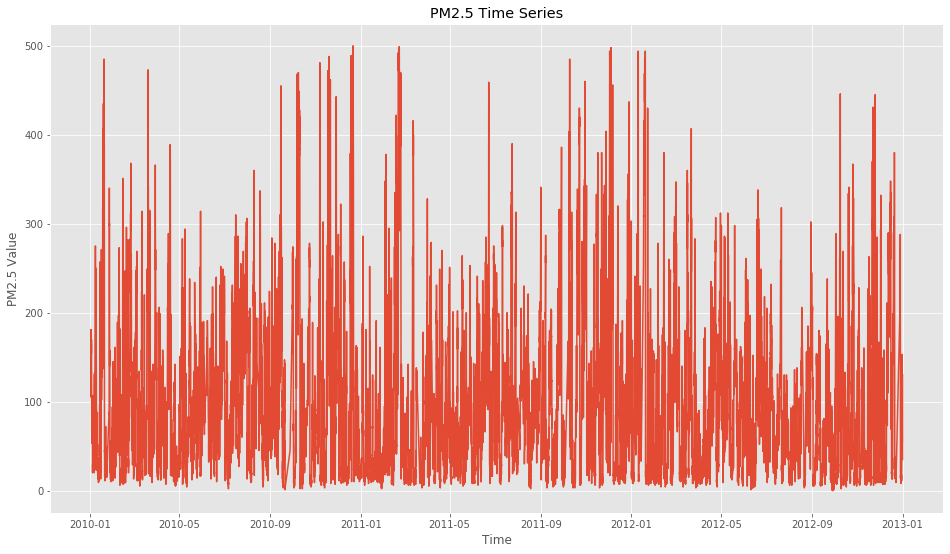

In [44]:
time_series('2010','2013')


I chose to remove any record with a PM2.5 value above 600 μg/m³. After doing my bit of study I learned that measured values above 500 μg/m³ may not be reliable. As the AQI scale only goes to 500 values, above this are simply considered extremely hazardous. 

In [45]:
#Above 500, all seem to be outliers.
#removing pm2.5 values greater than 500
print("Shape before: ", df.shape)
df = df[df['pm2.5'] <= 500]
print("Shape after: ", df.shape)

Shape before:  (41632, 25)
Shape after:  (41632, 25)


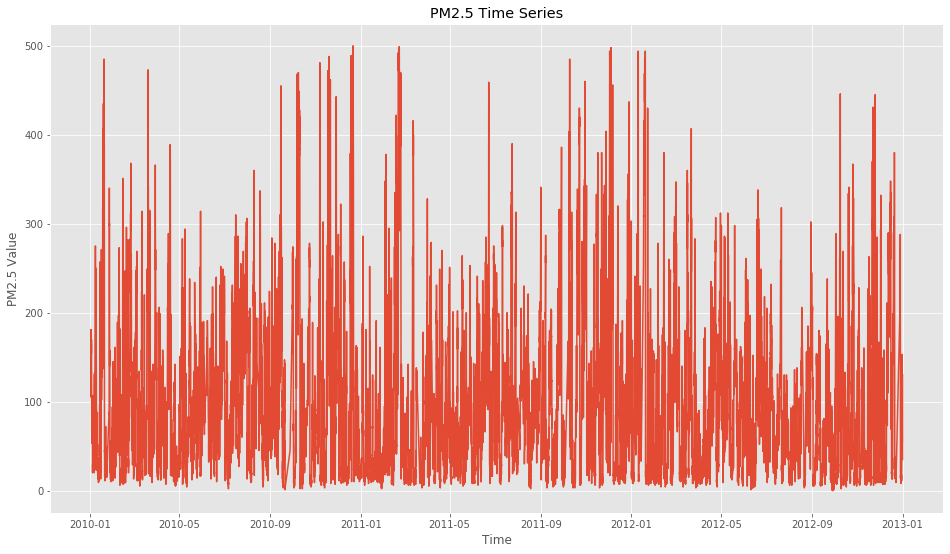

In [46]:
#Now lets visualize the time-series graph with clean data.
time_series('2010','2013')

In [55]:
#checking if there are null values
df.isnull().any()

MONTH    False
DATE     False
HOUR     False
CO        True
FSP       True
NO2       True
NOX       True
O3        True
RSP       True
SO2       True
DOW      False
dtype: bool

In [57]:
df.shape

(24840, 11)

There are a few records of RSP with missing data. Actually, Pandas provides at least 'ffill' and 'bfill' method to deal with the missing data. However, to ensure the accuracy of the analysis, I decided to try removing the NA records and this only reduces the size of whole dataset by around **1500 records**. 

In [58]:
#drop the null values
df = df.dropna()

In [59]:
df.shape

(23375, 11)

In [60]:
df.isnull().any()

MONTH    False
DATE     False
HOUR     False
CO       False
FSP      False
NO2      False
NOX      False
O3       False
RSP      False
SO2      False
DOW      False
dtype: bool

In [61]:
df.dtypes

MONTH             int64
DATE     datetime64[ns]
HOUR              int64
CO              float64
FSP             float64
NO2             float64
NOX             float64
O3              float64
RSP             float64
SO2             float64
DOW              object
dtype: object

## Visualizing the cleaned features

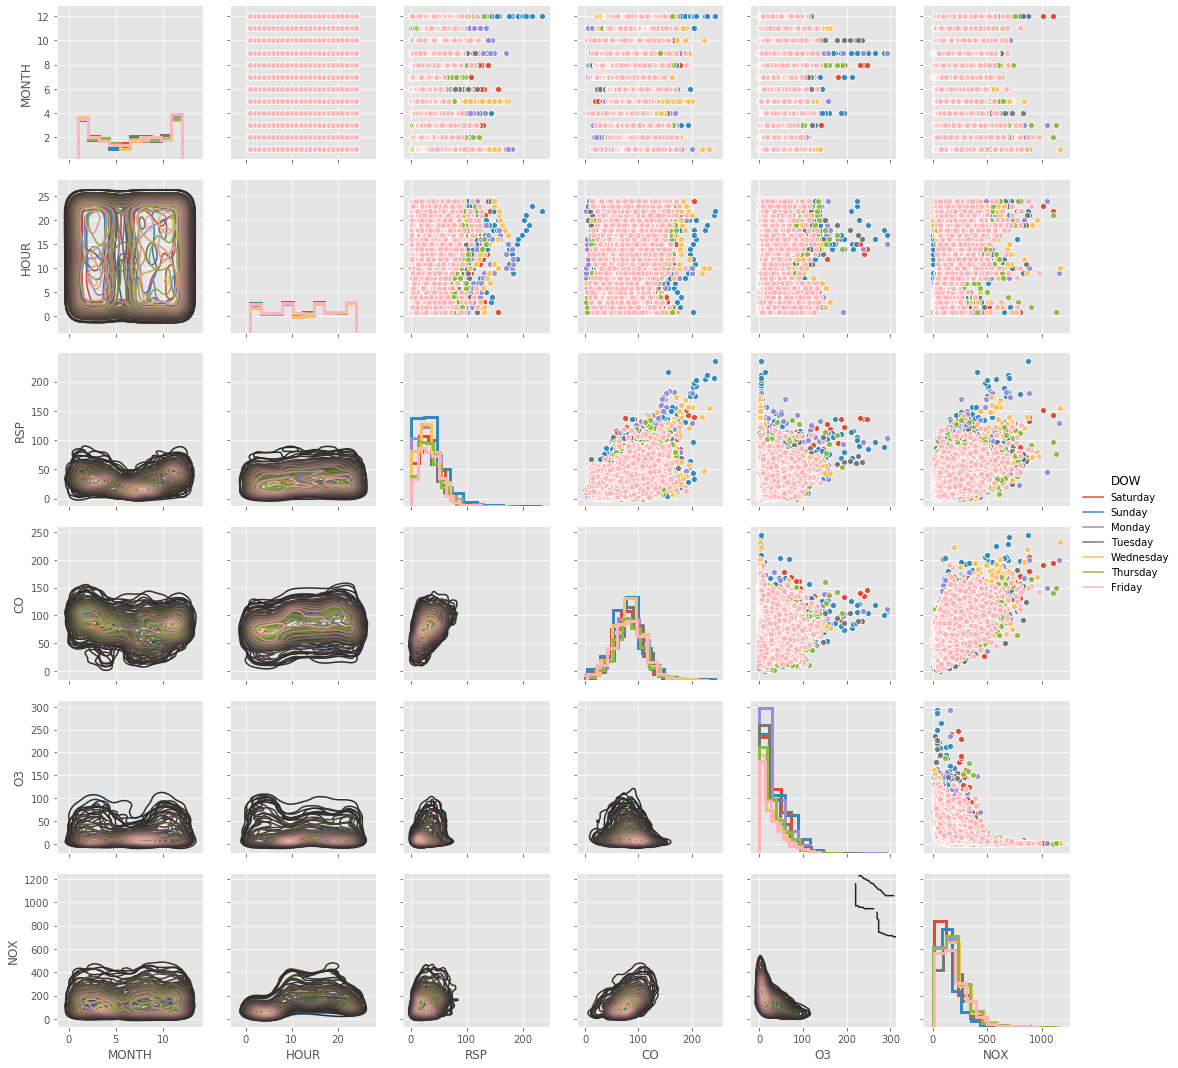

In [63]:
#correlation plot between the different features
g = sns.PairGrid(df, vars=["MONTH", "HOUR", "RSP", "CO", "O3", 'NOX'], dropna=True, hue="DOW")
g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

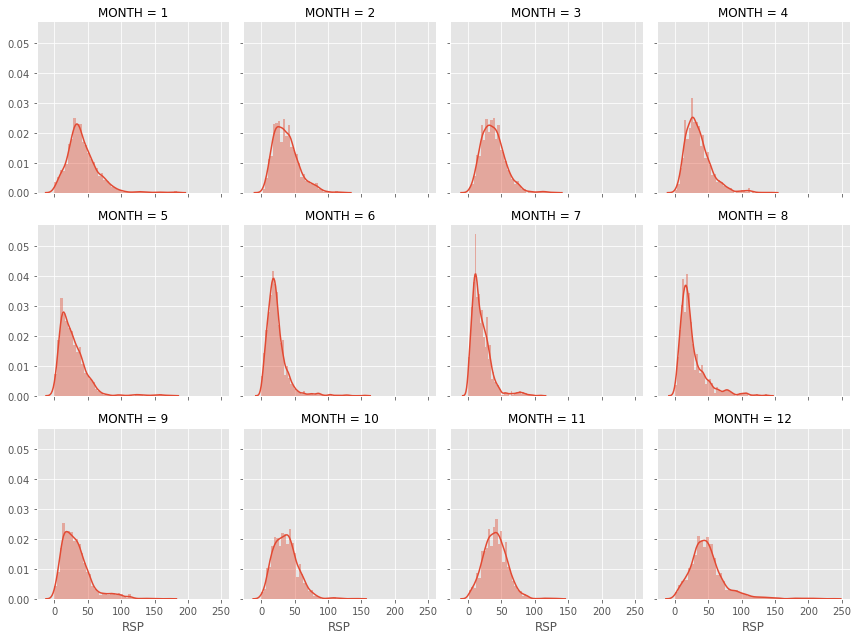

In [64]:
#RSP for every month
g = sns.FacetGrid(df, col='MONTH', col_wrap=4)
g.map(sns.distplot, "RSP")
plt.show()

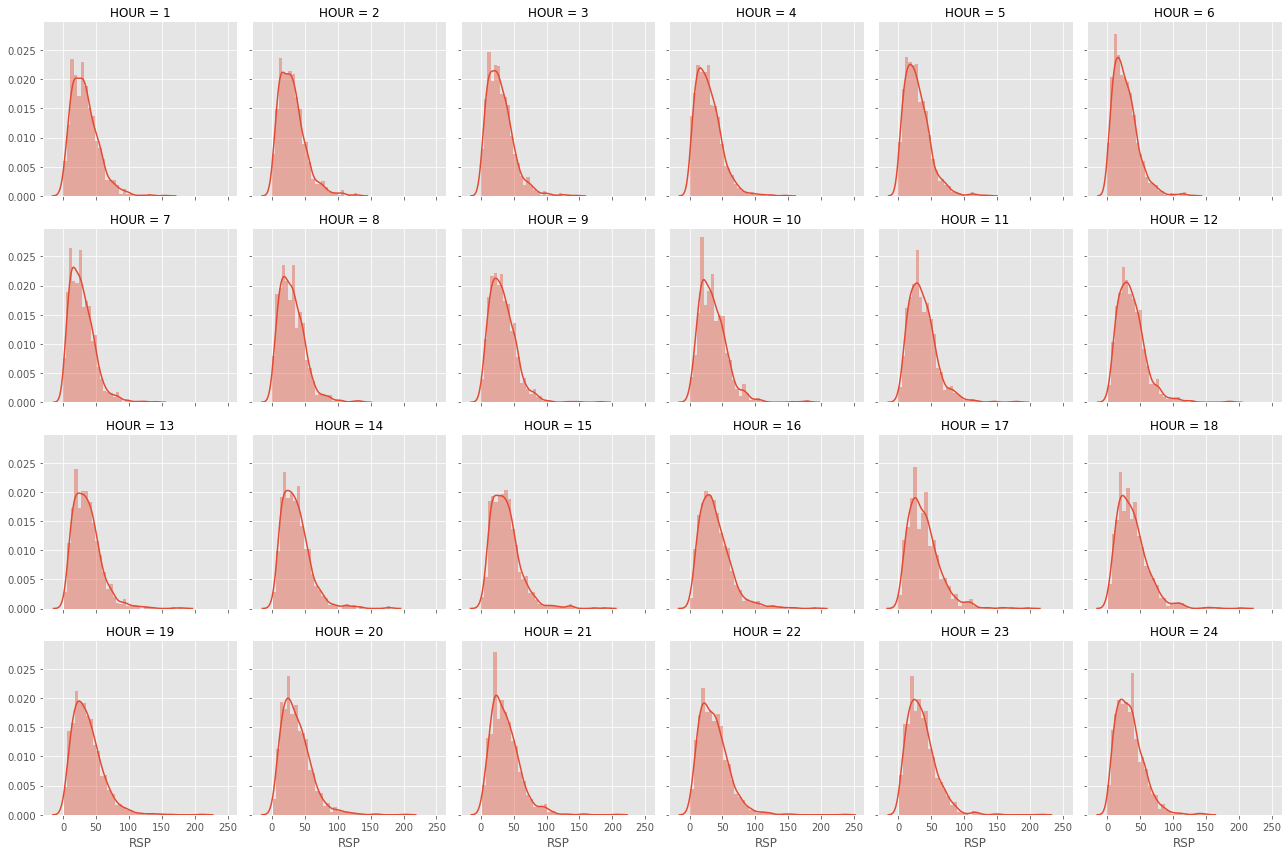

In [65]:
#RSP for every hour of the day
g = sns.FacetGrid(df, col='HOUR', col_wrap=6)
g.map(sns.distplot, "RSP")
plt.show()

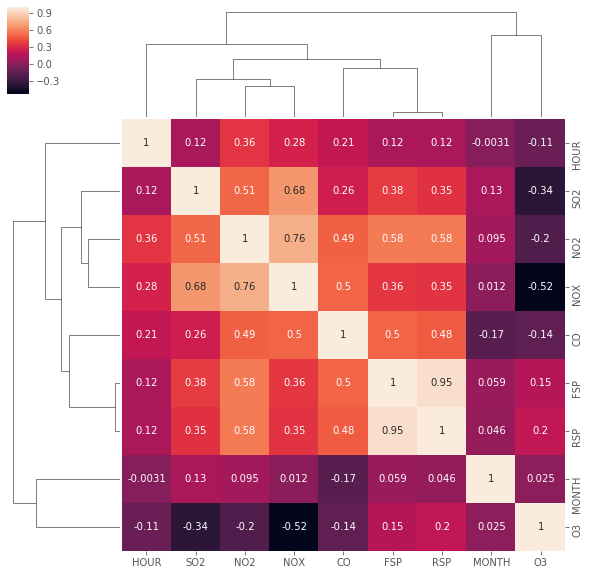

In [66]:
#correlation matrix of all the features
corr = df.corr()
sns.clustermap(corr, 
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values,
              annot=True,
              figsize=(10,10))
plt.gcf().get_axes()[2].set_ylim(corr.shape[0]-0.01, -0.01)
plt.show()

## Feature Engineering

In [74]:
df.head()

,MONTH,DATE,HOUR,CO,FSP,NO2,NOX,O3,RSP,SO2,DOW
0,7,2017-07-01,1,24.0,1.0,35.0,76.0,8.0,6.0,8.0,Saturday
3,7,2017-07-01,4,26.0,0.0,29.0,59.0,8.0,0.0,7.0,Saturday
4,7,2017-07-01,5,33.0,0.0,32.0,79.0,9.0,3.0,8.0,Saturday
5,7,2017-07-01,6,26.0,0.0,35.0,105.0,2.0,5.0,12.0,Saturday
7,7,2017-07-01,8,30.0,5.0,47.0,211.0,1.0,9.0,15.0,Saturday


## Split into Training and Test Data

We will split our data into training and test data using Scikit learn's built in libraries. We will also separate our dataset into inputs and feature matrices being predicted (or X's and y's).

In [69]:
#Traget / dependant variable
y = df['RSP']

In [93]:
# creating a matrix of independant variables
X = df.drop(['RSP', 'FSP'], axis=1)
X['DOW'] = X.DATE.dt.weekday
X = X.drop(['DATE'], axis=1)

In [94]:
#Splitting the data into training and test data - training - 70% and test - 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [95]:
X_train.shape, y_train.shape

((16362, 8), (16362,))

In [96]:
X_test.shape, y_test.shape

((7013, 8), (7013,))

In [97]:
X.columns

Index(['MONTH', 'HOUR', 'CO', 'NO2', 'NOX', 'O3', 'SO2', 'DOW'], dtype='object')

## Implementing the Machine Learning  Algorithms

Mainly, two kinds of methods are usually adopted in machine learning analysis: _classification_ and _regression_. Classification is about predicting a label; while, regression is about predicting a quantity. In this case, we are trying to predict the RSP level value. Hence, regression analysis is employed here. 

**Followuing algorithms will be used:**
1. Linear Regression
2. Losso Regression
3. Elastic Net Regression
4. Decision Forest
5. Ridge Regression
6. Neural Network
7. XgBoost
8. Extra Trees
9. Decision Tree
10. Boosted Decision Tree 

## 1. LINEAR REGRESSION

In [98]:
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
lin_pred = regr.predict(X_test)
linear_regression_score = regr.score(X_test, y_test)
print("Linear regression R-square: ", round(linear_regression_score, 4))

Linear regression R-square:  0.536


In [99]:
# Statistics !
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, lin_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, lin_pred))

Coefficients: 
 [ 0.03532753 -0.23619366  0.23957135  0.27890148 -0.03180015  0.25476895
  1.07827531  0.48296325]
Root mean squared error: 14.97
Mean absolute error: 10.88
R-squared: 0.54


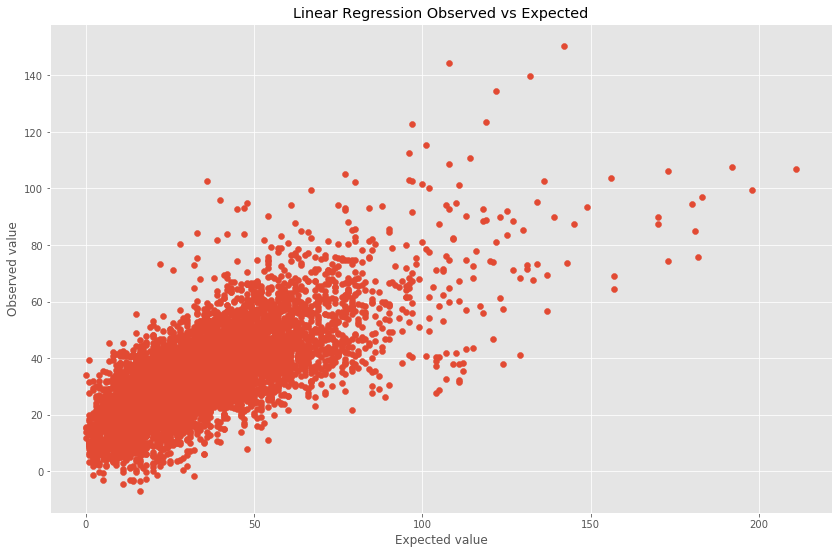

In [100]:
# Visualizing the observed vs predicted
plt.scatter(y_test, lin_pred)
plt.xlabel('Expected value')
plt.ylabel('Observed value')
plt.title('Linear Regression Observed vs Expected')
plt.show()

## RANDOM FOREST

In [101]:
# Create Random Forrest Regressor object
regr_rf = RandomForestRegressor(n_estimators=200, random_state=123)

In [102]:
# Train the model using the training sets
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [103]:
# Scoring the model
decision_forest_score = regr_rf.score(X_test, y_test)
print("Random Forest R-square: ", round(decision_forest_score, 4))

Random Forest R-square:  0.7366


In [104]:
# Make predictions using the testing set
regr_rf_pred = regr_rf.predict(X_test)

In [105]:
# Statistics
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

Root mean squared error: 11.28
Mean absolute error: 8.09
R-squared: 0.74


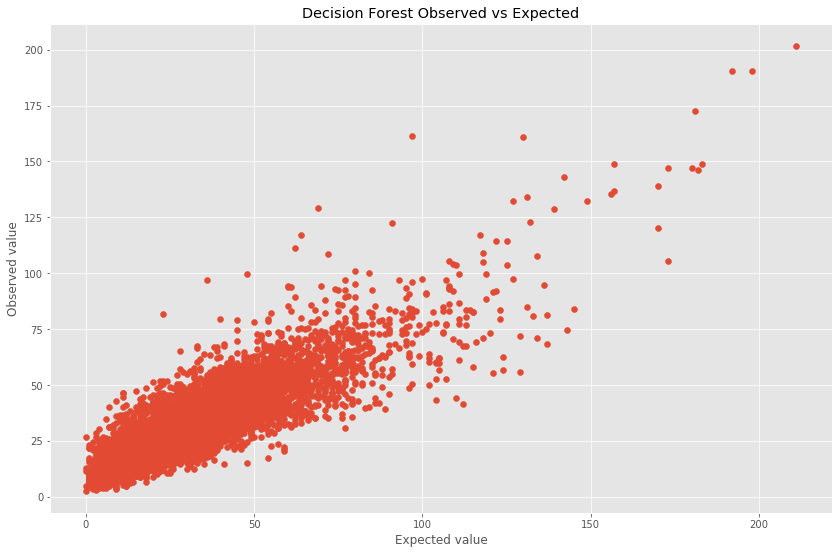

In [106]:
plt.scatter(y_test, regr_rf_pred)
plt.xlabel('Expected value')
plt.ylabel('Observed value')
plt.title('Decision Forest Observed vs Expected')
plt.show()

## LASSO REGRESSION

In [107]:
# Lasso Regression
lasso = Lasso()
lasso.fit(X_train, y_train)

# Scoring the model
lasso_score = lasso.score(X_test, y_test)
print("Lasso Regression R-square: ", round(lasso_score, 4))

Lasso Regression R-square:  0.5355


In [108]:
# Make predictions using the testing set
lasso_pred = lasso.predict(X_test)

print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lasso_pred)))

Root mean squared error: 14.98


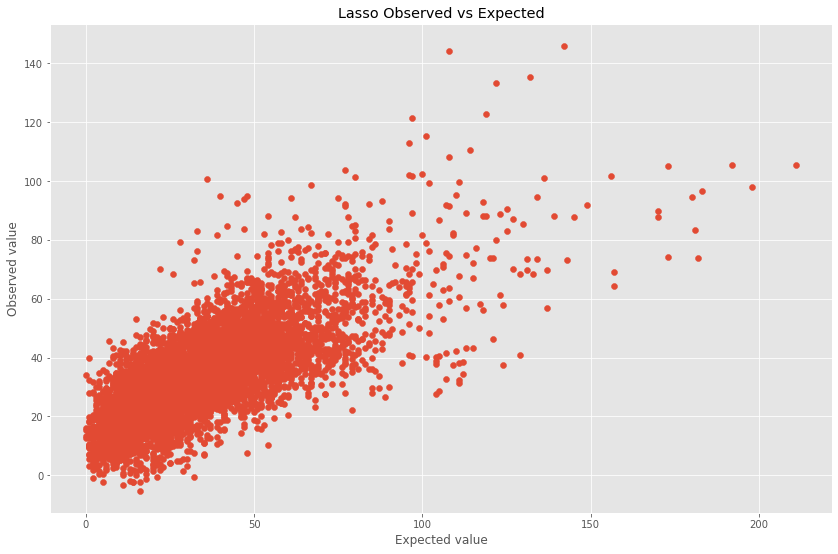

In [109]:
#Plotting the predictions
plt.scatter(y_test, lasso_pred)
plt.xlabel('Expected value')
plt.ylabel('Observed value')
plt.title('Lasso Observed vs Expected')
plt.show()

## ELASTICNET REGRESSION

In [110]:
elasticnet = ElasticNet()
elasticnet.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [111]:
#Scoring the model
elasticnet_score = elasticnet.score(X_test, y_test)
print("Elasticnet Regression R-square: ", round(elasticnet_score, 4))

Elasticnet Regression R-square:  0.5357


In [112]:
#Prediction
elasticnet_pred = elasticnet.predict(X_test)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, elasticnet_pred)))

Root mean squared error: 14.98


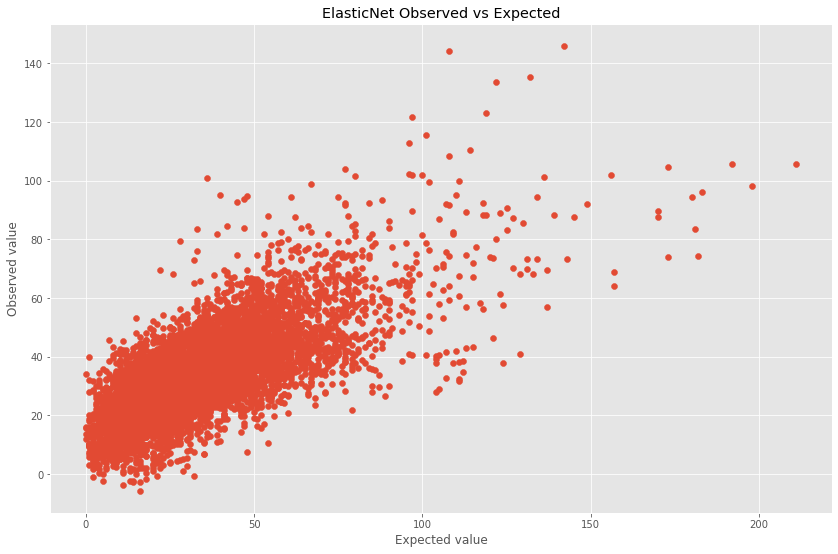

In [113]:
#Plotting the predictions
plt.scatter(y_test, elasticnet_pred)
plt.xlabel('Expected value')
plt.ylabel('Observed value')
plt.title('ElasticNet Observed vs Expected')
plt.show()

# RIDGE REGRESSION

In [114]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [115]:
Ridge_score = clf.score(X_test, y_test)
print("Ridge Regression R-square: ", round(Ridge_score, 4))

Ridge Regression R-square:  0.536


In [116]:
#Prediction
Ridge_pred = clf.predict(X_test)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, Ridge_pred)))

Root mean squared error: 14.97


# NAIVE BAYES

In [117]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [118]:
gnb_score = gnb.score(X_test, y_test)
print("Naive Bayesian mean accuracy: ", round(gnb_score, 4))

Naive Bayesian mean accuracy:  0.0311


In [119]:
#Prediction
y_pred = gnb.predict(X_test)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Root mean squared error: 19.41


# BAYESIAN RIDGE

In [120]:
clf = BayesianRidge(compute_score=True)
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [121]:
clf_score = clf.score(X_test, y_test)
print("Bayesian Ridge R-square: ", round(clf_score, 4))

Bayesian Ridge R-square:  0.536


In [122]:
#Prediction
clf_pred = clf.predict(X_test)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, clf_pred)))

Root mean squared error: 14.97


# MLP REGRESSOR

In [123]:
# Create MLPRegressor object
mlp = MLPRegressor()

In [124]:
# Train the model using the training sets
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [125]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
print("MLPRegressor R-square: ", round(neural_network_regression_score, 4))

MLPRegressor R-square:  0.5998


In [126]:
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)

In [127]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, nnr_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, nnr_pred))

Root mean squared error: 13.90
Mean absolute error: 10.32
R-squared: 0.60


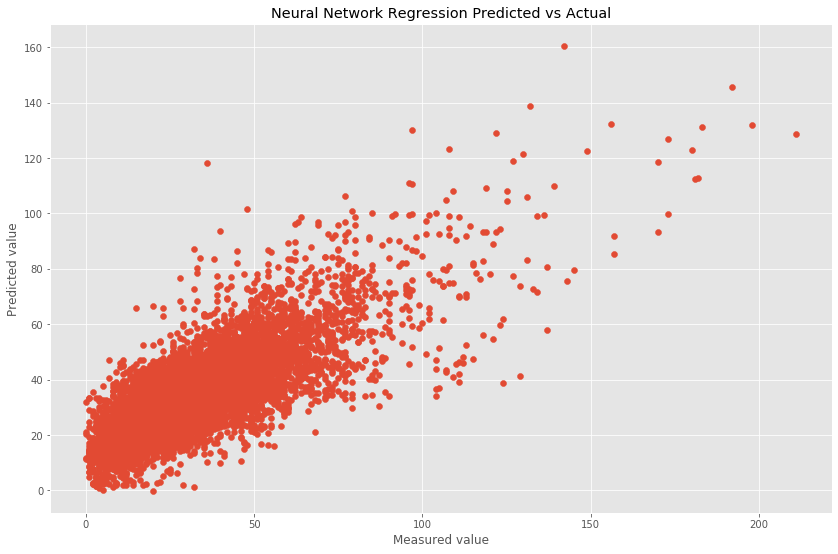

In [128]:
plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured value')
plt.ylabel('Predicted value')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

# ExtraTree Regression

In [129]:
extra_tree = ExtraTreesRegressor(n_estimators=200, random_state=1234)

In [130]:
extra_tree.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
                    oob_score=False, random_state=1234, verbose=0,
                    warm_start=False)

In [131]:
extratree_score = extra_tree.score(X_test, y_test)
print("ExtraTrees Regression R-square: ", round(extratree_score, 4))

ExtraTrees Regression R-square:  0.7691


In [132]:
extratree_pred = extra_tree.predict(X_test)

In [133]:
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, extratree_pred)))

Root mean squared error: 10.56


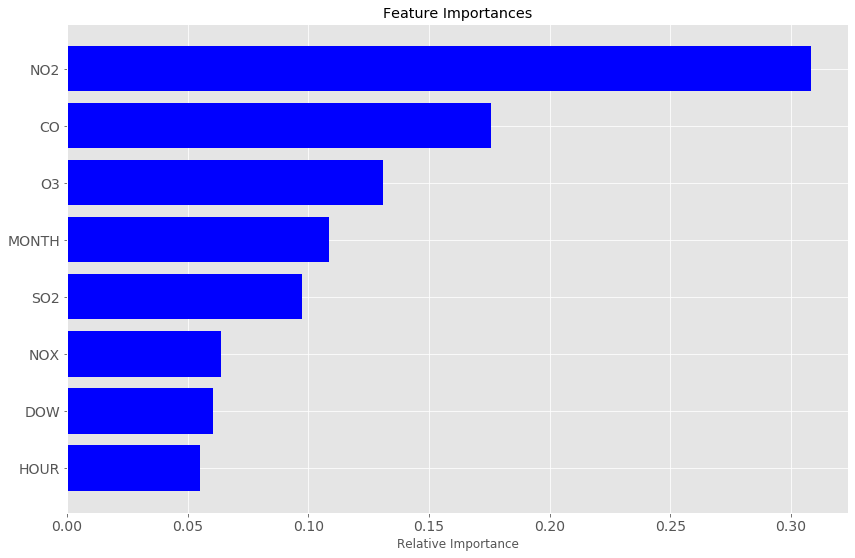

In [143]:
features = X.columns
importances = extra_tree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices], fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Relative Importance')
plt.show()

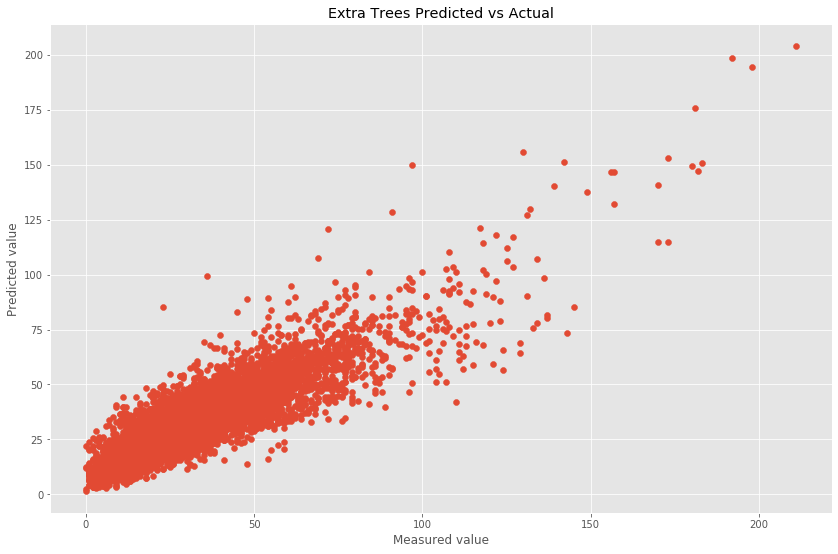

In [144]:
plt.scatter(y_test, extratree_pred)
plt.xlabel('Measured value')
plt.ylabel('Predicted value')
plt.title('Extra Trees Predicted vs Actual')
plt.show()

# DECISION TREE AND ADA BOOST

In [147]:
# Create Decision Tree Regressor object
tree_1 = DecisionTreeRegressor()

tree_2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=200, learning_rate=.1)

In [148]:
# Train the model using the training sets
tree_1.fit(X_train, y_train)
tree_2.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=200,
                  rand

In [149]:
# Score the decision tree model
tree_1_score = tree_1.score(X_test, y_test)
print("Decision Tree R-square: ", round(tree_1_score, 4))

Decision Tree R-square:  0.4536


In [150]:
# Score the boosted decision tree model
tree_2_score = tree_2.score(X_test, y_test)
print("Adaptative-boosted Decision Tree R-square: ", round(tree_2_score, 4))

Adaptative-boosted Decision Tree R-square:  0.7528


In [151]:
# Make predictions using the testing set
tree_1_pred = tree_1.predict(X_test)
tree_2_pred = tree_2.predict(X_test)

In [152]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
print("General Decision Tree:")
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, tree_1_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, tree_1_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, tree_1_pred))

General Decision Tree:
Root mean squared error: 16.24
Mean absolute error: 11.22
R-squared: 0.45


In [153]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
print("Adaboost Decision Tree:")
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, tree_2_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, tree_2_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, tree_2_pred))

Adaboost Decision Tree:
Root mean squared error: 10.93
Mean absolute error: 7.54
R-squared: 0.75


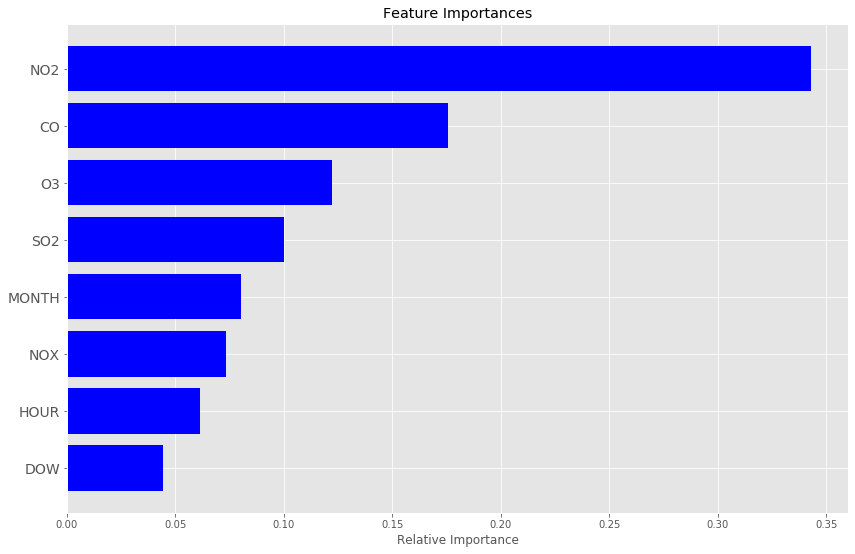

In [156]:
features = X.columns
importances = tree_2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices], fontsize=14)
plt.xlabel('Relative Importance')
plt.show()

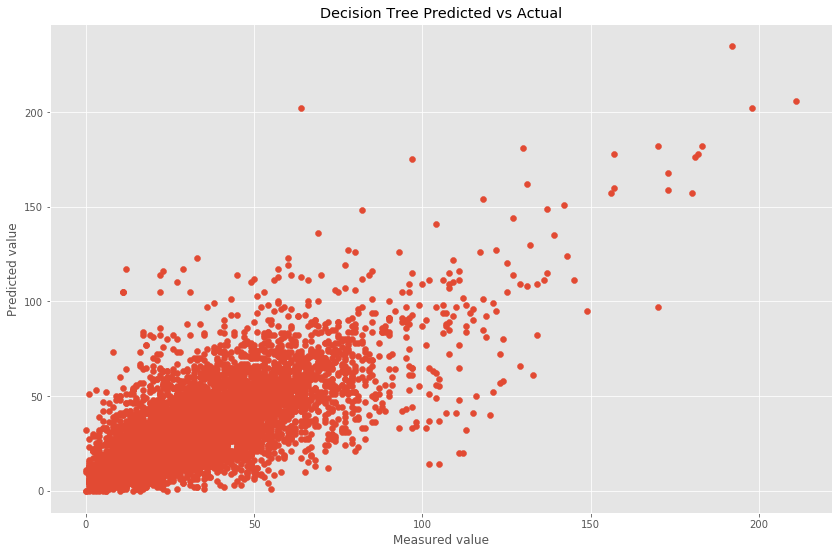

In [157]:
plt.scatter(y_test, tree_1_pred)
plt.xlabel('Measured value')
plt.ylabel('Predicted value')
plt.title('Decision Tree Predicted vs Actual')
plt.show()

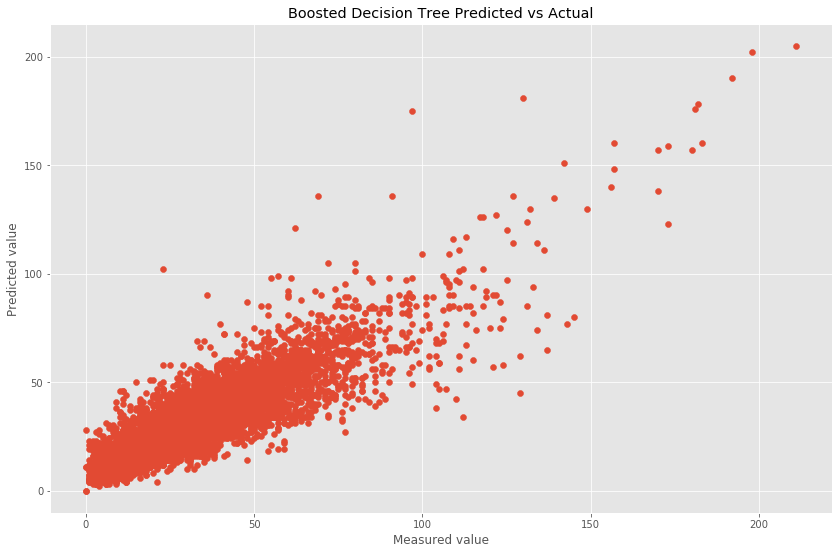

In [158]:
plt.scatter(y_test, tree_2_pred)
plt.xlabel('Measured value')
plt.ylabel('Predicted value')
plt.title('Boosted Decision Tree Predicted vs Actual')
plt.show()

# EXTREME GRADIENT BOOST

In [112]:
# !pip install xgboost

In [159]:
#Fitting XGB regressor 
xboost = XGBRegressor(n_estimators=200)

In [160]:
xboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [161]:
xgb_score = xboost.score(X_test, y_test)
print("Extreme Gradient Boost R-square: ", round(xgb_score, 4))

Extreme Gradient Boost R-square:  0.7382


In [162]:
#Predict 
xboost_pred = xboost.predict(X_test)

In [163]:
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, xboost_pred)))

Root mean squared error: 11.25


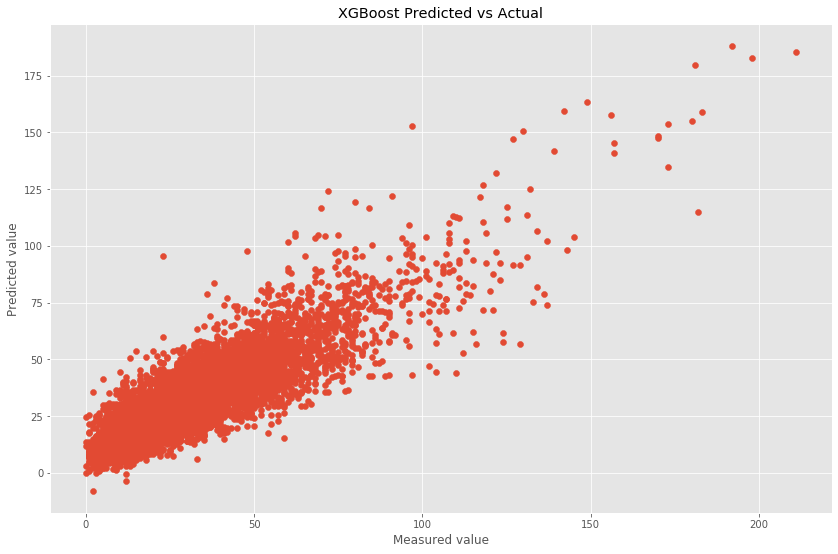

In [164]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured value')
plt.ylabel('Predicted value')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [168]:
# print("COMPARISON SCORES - Feature shifting by 3 hours")
print("COMPARISON SCORES - No time shifted")
print("\n")
print("Linear regression score: ", round(linear_regression_score, 4))
print("Lasso regression score: ", round(lasso_score, 4))
print("ElasticNet regression score: ", round(elasticnet_score, 4))
print("Random forest score: ", round(decision_forest_score, 4))
print("Neural network regression score: ", round(neural_network_regression_score, 4))
print("ExtraTrees score: ", round(extratree_score, 4))
print("Decision Tree score: ", round(tree_1_score, 4))
print("Boosted-decision tree score: ", round(tree_2_score, 4))
print("XGBoost score:", round(xgb_score, 4))
print("Ridge Regression score:", round(Ridge_score, 4))
print("Naive Bayes score:", round(gnb_score, 4))
print("\n")
print("RMSE:")
print("Linear regression RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
print("Lasso RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, lasso_pred)))
print("ElasticNet RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, elasticnet_pred)))
print("Decision forest RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, regr_rf_pred)))
print("Neural network RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
print("ExtraTrees RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, extratree_pred)))
print("Decision tree RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, tree_1_pred)))
print("Boosted decision tree RMSE: %.2f"
     % sqrt(mean_squared_error(y_test, tree_2_pred)))
print("XGBoost RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, xboost_pred)))
print("Ridge Regression RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, Ridge_pred)))
print("Naive Bayes RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, clf_pred)))

COMPARISON SCORES - No time shifted


Linear regression score:  0.536
Lasso regression score:  0.5355
ElasticNet regression score:  0.5357
Random forest score:  0.7366
Neural network regression score:  0.5998
ExtraTrees score:  0.7691
Decision Tree score:  0.4536
Boosted-decision tree score:  0.7528
XGBoost score: 0.7382
Ridge Regression score: 0.536
Naive Bayes score: 0.0311


RMSE:
Linear regression RMSE: 14.97
Lasso RMSE: 14.98
ElasticNet RMSE: 14.98
Decision forest RMSE: 11.28
Neural network RMSE: 13.90
ExtraTrees RMSE: 10.56
Decision tree RMSE: 16.24
Boosted decision tree RMSE: 10.93
XGBoost RMSE: 11.25
Ridge Regression RMSE: 14.97
Naive Bayes RMSE: 14.97


Of all the models used, the ExtraTrees model scores the highest (0.7691) with the least RMSE (10.56).

TRIED TO USE LSTM - BUT WAS NOT SUCCESSFUL - HAVE THIS FOR FUTURE WORK

In [120]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# #create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)